In [1]:
import torch.nn as nn
import torchvision.models as models
import torch

Adapted from this wonderful tutorial:

https://www.youtube.com/watch?v=y2BaTt1fxJU&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=21

In [2]:
class encoderCNN(nn.Module):
    def __init__(self, embed_size, should_train=False):
        super(encoderCNN, self).__init__()
        self.should_train = should_train
        self.inception = models.inception_v3(pretrained=True, aux_logits=True)
#         self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.dropout= nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        features, _ = self.inception(x)
        
#         for name, param in self.inception.named_parameters():
#             param.requires_grad = False
        return self.dropout(self.relu(features))
        

In [3]:
class decoderRNN(nn.Module):
    def __init__(self, embed_size,vocab_size, hidden_size, num_layers):
        super(decoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, caption):
        embeddings = self.dropout(self.embedding(caption))
        embeddings = torch.cat((features.unsqueeze(0),embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [4]:
class CNN2RNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers):
        super(CNN2RNN, self).__init__()
        self.encoderCNN = encoderCNN(embed_size)
        self.decoderRNN = decoderRNN(embed_size, vocab_size, hidden_size, num_layers)
    
    def forward(self, images, caption):
        x = self.encoderCNN(images)
        x = self.decoderRNN(x, caption)
        return x
    
    def captionImage(self, image, vocabulary, maxlength=50):
        result_caption = []
        
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None
            
            for _ in range(maxlength):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                print(predicted.shape)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embedding(output).unsqueeze(0)
                
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
        return [vocabulary.itos[i] for i in result_caption]

## Getting the dataset

In [5]:
import os
import pandas
import spacy

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from torchvision.transforms import transforms

2023-03-29 20:37:48.738359: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [6]:
# spacy_eng = spacy.load("en")
spacy_eng = spacy.load("en_core_web_sm")

/scratch/w880c134/anaconda3/envs/tf/lib/python3.9/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [7]:
class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}
        
        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (frequency[word] > self.freq_threshold-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]
                    
        

In [8]:
annotation = pandas.read_csv("data/flickr8k/captions.txt")
annotation.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [9]:
annotation['caption'].tolist()[:2]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .']

In [10]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir="data/flickr8k/images", 
                 caption_path="data/flickr8k/captions.txt", 
                 freq_threshold=5, transform=None, data_length=10000):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pandas.read_csv(caption_path)[:data_length]
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        
        self.vocab = Vocabulary(freq_threshold)
        
        print(len(self.captions.tolist()))
        self.vocab.build_vocabulary(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [11]:
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_value)
        
        return img, targets

In [12]:
# transform = transforms.Compose(
#         [transforms.Resize((224, 224)), transforms.ToTensor(),]
#     )

transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [13]:
def get_loader(root_dir="data/flickr8k/images", 
               caption_path="data/flickr8k/captions.txt", 
               transform=transform, 
               batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir,caption_path=caption_path, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]
    
    loader = DataLoader(dataset=dataset, batch_size=32, num_workers=6, shuffle=True, pin_memory=True, collate_fn=MyCollate(pad_value))
    
    return loader, dataset

In [14]:
 loader, dataset = get_loader()

10000


Lets load a random example.

In [15]:
import random
import math

x, y = dataset[math.floor(random.random() * len(dataset))]
x.shape, y.shape

(torch.Size([3, 299, 299]), torch.Size([16]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([     1, 108926, 108621, 108927, 108922, 108926, 108830, 108898, 108917,
        108664, 108899, 108926, 106320, 101133, 108925,      2])
<SOS> a little boy with a green shirt is running on a rock ledge . <EOS> 

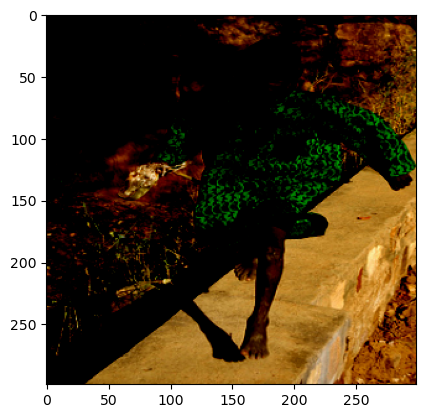

In [16]:
import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))
print(y)

# print(dataset.vocab.itos[1])

for i in y:
    print(dataset.vocab.itos[int(i)],end=" ")

In [17]:
def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
    print("saving checkpoint!")
    torch.save(state, filename)

In [18]:
def load_checkpoint(checkpoint, model, optimizer):
    print("loading checkpoint!")
    model.load_state_dict(checkpoint["state_dict"])
    model.load_state_optimizer(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

## Training the model

In [19]:
from tqdm import tqdm
# from torchvision.utils.tensorboard import SummaryWriter

In [20]:
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
load_model = False
save_model=False
train_CNN = False

In [21]:
# model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers).to(device=device)

### Hyperparameters

In [22]:
import torch.optim as optim 

step = 0
embed_size = 256
hidden_size = 256
num_layers = 5
num_epochs = 3
learning_rate = 3e-4
vocab_size = len(dataset.vocab)


In [23]:
model = CNN2RNN(embed_size=embed_size, 
                hidden_size=hidden_size,
                vocab_size=vocab_size, 
                num_layers=num_layers).to(device=device)

/scratch/w880c134/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/w880c134/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
model.decoderRNN

# print('model: ',model)
# print('device: ', device)

decoderRNN(
  (embedding): Embedding(108931, 256)
  (lstm): LSTM(256, 256, num_layers=5)
  (linear): Linear(in_features=256, out_features=108931, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [25]:
loss_criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [26]:
# # Only finetune the CNN
# for name, param in model.encoderCNN.inception.named_parameters():
#     if "fc.weight" in name or "fc.bias" in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = train_CNN

In [27]:
if load_model:
    step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

In [28]:
model.train()

for epoch in range(num_epochs):
    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": model.state_dict(),
            "step": step,
        }
        save_checkpoint(checkpoint)

#     for idx, (imgs, captions) in tqdm(
#         enumerate(loader), total=len(loader), leave=False
#     ):
    for idx, (imgs, captions) in enumerate(loader):
        imgs = imgs.to(device)
        captions = captions.to(device)
        
        score = model(imgs, captions[:-1])
        
#         print(score.shape, captions.shape)
#         print(score.reshape(-1, score.shape[2]).shape, captions.reshape(-1).shape)
#         print("why are we reshaping it here?")
        optimizer.zero_grad()
        loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))
              
        step += 1
        
        loss.backward()
        optimizer.step()
    print(f"Loss for epoch {epoch}: {loss}")

Loss for epoch 0: 4.586568832397461
Loss for epoch 1: 4.164608955383301
Loss for epoch 2: 4.2437005043029785


In [29]:
image_path = "data/flickr8k/images/1032460886_4a598ed535.jpg"
img = Image.open(image_path)
img = transform(img)

# plt.imshow(img.permute(1,2,0))

# img = img.unsqueeze(0)
image_input = img.to(device=device) # check here
print(image_input.shape)

model.eval()
print(model.captionImage(image=image_input, vocabulary=dataset.vocab))




torch.Size([3, 299, 299])


ValueError: expected 4D input (got 3D input)